In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [6]:
df = pd.read_csv('train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [11]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [12]:
{column: len(df[column].unique()) for column in df.columns}

{'date': 1826, 'store': 10, 'item': 50, 'sales': 213}

In [17]:
print('- Data collection from', df['date'].min(), 'to', df['date'].max())
print('- Dataset includes 50 items from 10 stores')

- Data collection from 2013-01-01 00:00:00 to 2017-12-31 00:00:00
- Dataset includes 50 items from 10 stores


In [22]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.dayofyear
df['weekday'] = df['date'].dt.weekday

df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


In [47]:
df.sort_values('date').head(10)

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
211816,2013-01-01,7,12,26,2013,1,1,1
832656,2013-01-01,7,46,27,2013,1,1,1
213642,2013-01-01,8,12,54,2013,1,1,1
215468,2013-01-01,9,12,35,2013,1,1,1
217294,2013-01-01,10,12,41,2013,1,1,1
830830,2013-01-01,6,46,23,2013,1,1,1
219120,2013-01-01,1,13,37,2013,1,1,1
220946,2013-01-01,2,13,51,2013,1,1,1
829004,2013-01-01,5,46,20,2013,1,1,1


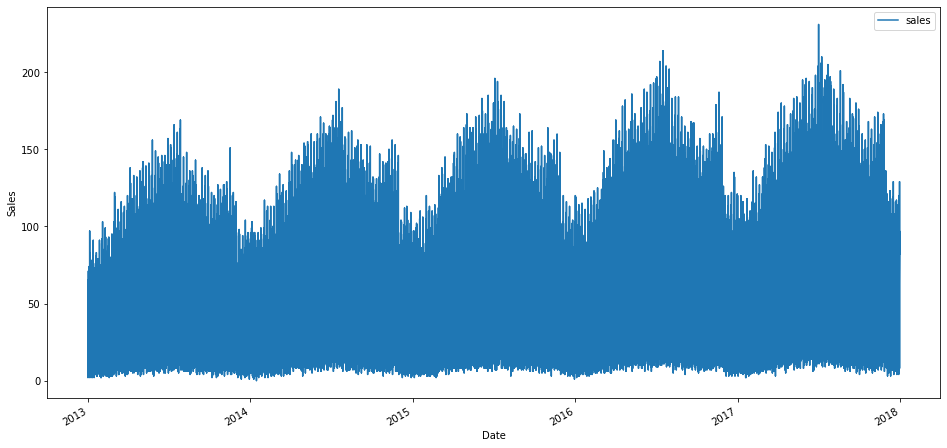

In [60]:
df.plot(x='date', y='sales', figsize=(16,8))
plt.ylabel('Sales')
plt.xlabel('Date')
plt.show();

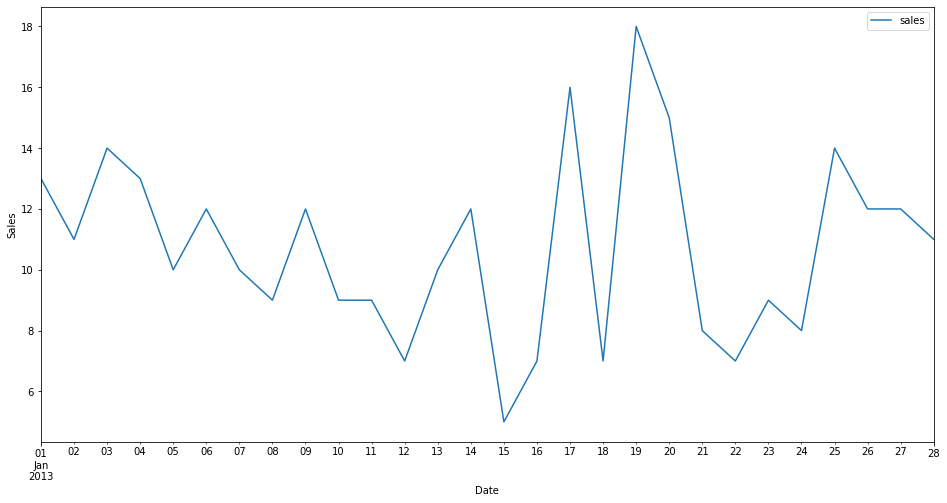

In [61]:
df[:28].plot(x='date', y='sales', figsize=(16,8))
plt.ylabel('Sales')
plt.xlabel('Date')
plt.show();